In [1]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    f1_score,
    precision_score,
    recall_score
)
from transformers import pipeline

### Load Model

In [2]:
MODEL_PATH = "../models/condition_classifier/final"
DATA_PATH = "../data/classifier"

# Load label mappings
with open(f"{DATA_PATH}/label2id.json", 'r') as f:
    label2id = json.load(f)

with open(f"{DATA_PATH}/id2label.json", 'r') as f:
    id2label = {int(k): v for k, v in json.load(f).items()}

# Load test data
with open(f"{DATA_PATH}/test.json", 'r') as f:
    test_data = json.load(f)

# Load train data for leakage check
with open(f"{DATA_PATH}/train.json", 'r') as f:
    train_data = json.load(f)

print(f"Train samples: {len(train_data):,}")
print(f"Test samples: {len(test_data):,}")
print(f"Number of classes: {len(label2id)}")

# Load model
device = 0 if torch.cuda.is_available() else -1
classifier = pipeline(
    "text-classification",
    model=MODEL_PATH,
    tokenizer=MODEL_PATH,
    device=device,
    top_k=1
)

Train samples: 1,025,602
Test samples: 134,529
Number of classes: 49


Device set to use cuda:0


###  Data Leakage Check

In [3]:
print("DATA LEAKAGE CHECK")

# Extract all text from train and test
train_texts = set(item['text'] for item in train_data)
test_texts = set(item['text'] for item in test_data)

# Check for exact duplicates
exact_overlap = train_texts.intersection(test_texts)

print(f"\nExact duplicate texts in both train and test: {len(exact_overlap)}")

if len(exact_overlap) > 0:
    print("\nWARNING: Data leakage detected!")
    print("Sample overlapping texts:")
    for i, text in enumerate(list(exact_overlap)[:3]):
        print(f"   {i+1}. {text[:80]}...")
else:
    print("No exact duplicates found between train and test sets.")

# Check for near-duplicates (same symptoms, different order might exist)
# Using first 50 characters as a proxy
train_prefixes = Counter(item['text'][:50] for item in train_data)
test_prefixes = Counter(item['text'][:50] for item in test_data)

prefix_overlap = set(train_prefixes.keys()).intersection(set(test_prefixes.keys()))
print(f"\nTexts with same first 50 characters: {len(prefix_overlap)}")

if len(prefix_overlap) > 100:
    print(" WARNING: Potential near-duplicates detected!")
else:
    print("Minimal near-duplicate overlap.")

DATA LEAKAGE CHECK

Exact duplicate texts in both train and test: 13633

Sample overlapping texts:
   1. Patient presents with: Do you regularly take stimulant drugs; experiencing short...
   2. Patient presents with: severe Chronic Obstructive Pulmonary Disease (COPD); had ...
   3. Patient presents with: had 2 or more asthma attacks in the past year; experienci...

Texts with same first 50 characters: 134


### Class Distribution Check

CLASS DISTRIBUTION ANALYSIS

Class Distribution (sorted by train count):
Condition                                Train %    Test %    
URTI                                     6.28       6.50      
Viral pharyngitis                        6.01       6.19      
Anemia                                   4.94       5.09      
HIV (initial infection)                  2.83       2.91      
Localized edema                          2.71       2.78      
Anaphylaxis                              2.70       2.82      
Pulmonary embolism                       2.68       2.73      
Influenza                                2.61       2.64      
Bronchitis                               2.57       2.67      
Allergic sinusitis                       2.55       1.79      
Acute dystonic reactions                 2.53       2.45      
GERD                                     2.53       2.63      
Acute otitis media                       2.53       2.61      
Pneumonia                                2.51

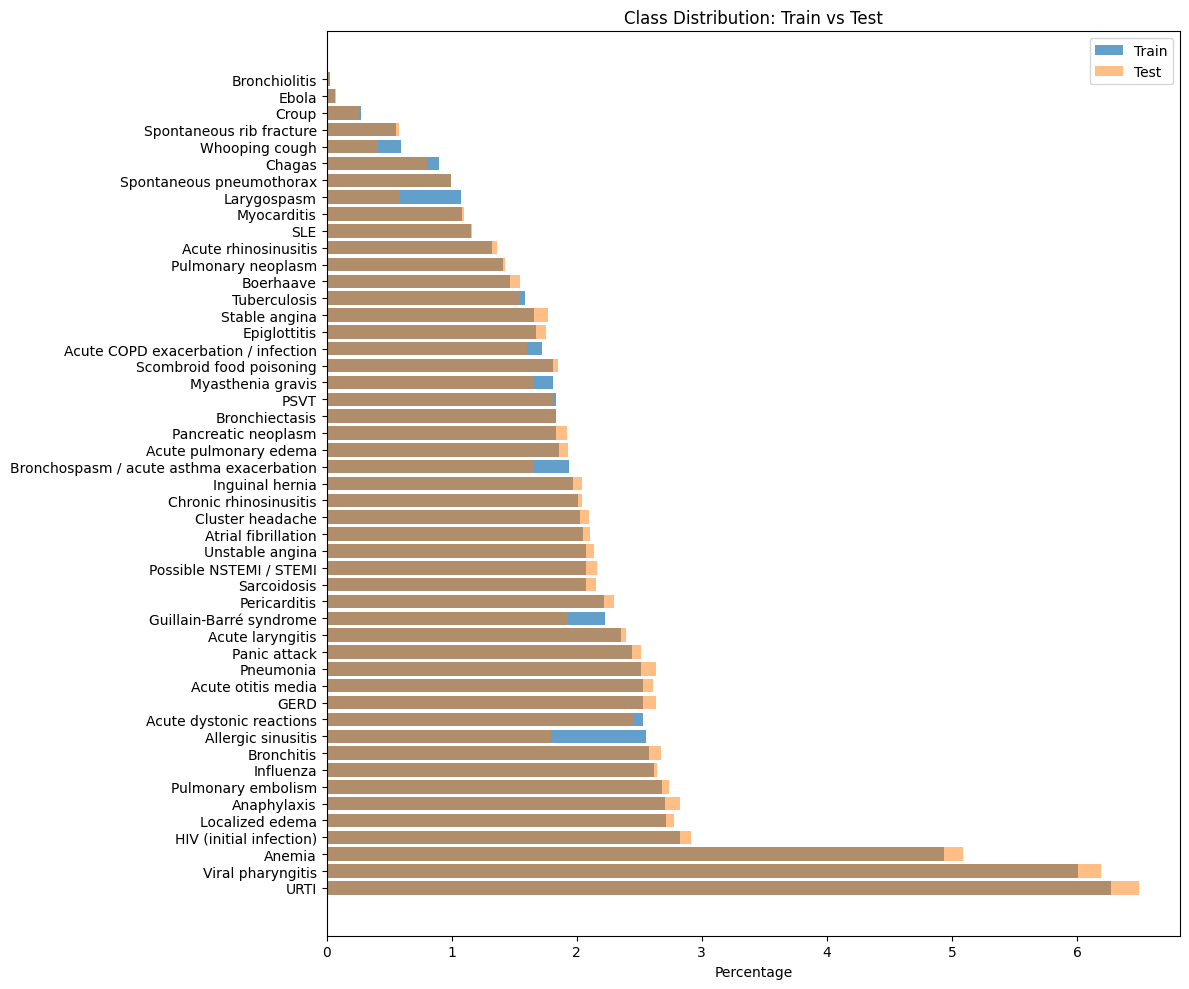

In [4]:
print("CLASS DISTRIBUTION ANALYSIS")

# Count conditions in test set
test_conditions = Counter(item['condition'] for item in test_data)
train_conditions = Counter(item['condition'] for item in train_data)

# Create comparison DataFrame
distribution_df = pd.DataFrame({
    'condition': list(label2id.keys()),
    'train_count': [train_conditions.get(c, 0) for c in label2id.keys()],
    'test_count': [test_conditions.get(c, 0) for c in label2id.keys()],
})

distribution_df['train_pct'] = distribution_df['train_count'] / len(train_data) * 100
distribution_df['test_pct'] = distribution_df['test_count'] / len(test_data) * 100
distribution_df['pct_diff'] = abs(distribution_df['train_pct'] - distribution_df['test_pct'])

distribution_df = distribution_df.sort_values('train_count', ascending=False)

print("\nClass Distribution (sorted by train count):")

print(f"{'Condition':<40} {'Train %':<10} {'Test %':<10}")

for _, row in distribution_df.iterrows():
    print(f"{row['condition']:<40} {row['train_pct']:<10.2f} {row['test_pct']:<10.2f}")

# Check imbalance ratio
max_count = distribution_df['train_count'].max()
min_count = distribution_df['train_count'].min()
imbalance_ratio = max_count / min_count

print("IMBALANCE SUMMARY")

print(f"Most common class: {distribution_df.iloc[0]['condition']} ({distribution_df.iloc[0]['train_count']:,} samples)")
print(f"Least common class: {distribution_df.iloc[-1]['condition']} ({distribution_df.iloc[-1]['train_count']:,} samples)")
print(f"Imbalance ratio: {imbalance_ratio:.1f}:1")

if imbalance_ratio > 100:
    print(" WARNING: Severe class imbalance detected!")
elif imbalance_ratio > 50:
    print(" NOTICE: Moderate class imbalance present.")
else:
    print(" Class imbalance is manageable.")

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
y_pos = range(len(distribution_df))
ax.barh(y_pos, distribution_df['train_pct'], alpha=0.7, label='Train')
ax.barh(y_pos, distribution_df['test_pct'], alpha=0.5, label='Test')
ax.set_yticks(y_pos)
ax.set_yticklabels(distribution_df['condition'])
ax.set_xlabel('Percentage')
ax.set_title('Class Distribution: Train vs Test')
ax.legend()
plt.tight_layout()
plt.show()

### Generate Predictions on Test Set

In [5]:
print("GENERATING PREDICTIONS ON TEST SET")

# Generate predictions
y_true = []
y_pred = []

batch_size = 100
total = len(test_data)

for i in range(0, total, batch_size):
    batch = test_data[i:i+batch_size]
    texts = [item['text'] for item in batch]
    true_labels = [item['condition'] for item in batch]
    
    # Predict
    predictions = classifier(texts)
    pred_labels = [p[0]['label'] for p in predictions]
    
    y_true.extend(true_labels)
    y_pred.extend(pred_labels)
    
    # Progress
    if (i // batch_size) % 10 == 0:
        print(f"   Progress: {i:,} / {total:,} ({i/total*100:.1f}%)")

print(f"\nPredictions complete: {len(y_pred):,} samples")


GENERATING PREDICTIONS ON TEST SET
   Progress: 0 / 134,529 (0.0%)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


   Progress: 1,000 / 134,529 (0.7%)
   Progress: 2,000 / 134,529 (1.5%)
   Progress: 3,000 / 134,529 (2.2%)
   Progress: 4,000 / 134,529 (3.0%)
   Progress: 5,000 / 134,529 (3.7%)
   Progress: 6,000 / 134,529 (4.5%)
   Progress: 7,000 / 134,529 (5.2%)
   Progress: 8,000 / 134,529 (5.9%)
   Progress: 9,000 / 134,529 (6.7%)
   Progress: 10,000 / 134,529 (7.4%)
   Progress: 11,000 / 134,529 (8.2%)
   Progress: 12,000 / 134,529 (8.9%)
   Progress: 13,000 / 134,529 (9.7%)
   Progress: 14,000 / 134,529 (10.4%)
   Progress: 15,000 / 134,529 (11.2%)
   Progress: 16,000 / 134,529 (11.9%)
   Progress: 17,000 / 134,529 (12.6%)
   Progress: 18,000 / 134,529 (13.4%)
   Progress: 19,000 / 134,529 (14.1%)
   Progress: 20,000 / 134,529 (14.9%)
   Progress: 21,000 / 134,529 (15.6%)
   Progress: 22,000 / 134,529 (16.4%)
   Progress: 23,000 / 134,529 (17.1%)
   Progress: 24,000 / 134,529 (17.8%)
   Progress: 25,000 / 134,529 (18.6%)
   Progress: 26,000 / 134,529 (19.3%)
   Progress: 27,000 / 134,529 (20.

### Confusion Matrix Analysis

CONFUSION MATRIX ANALYSIS


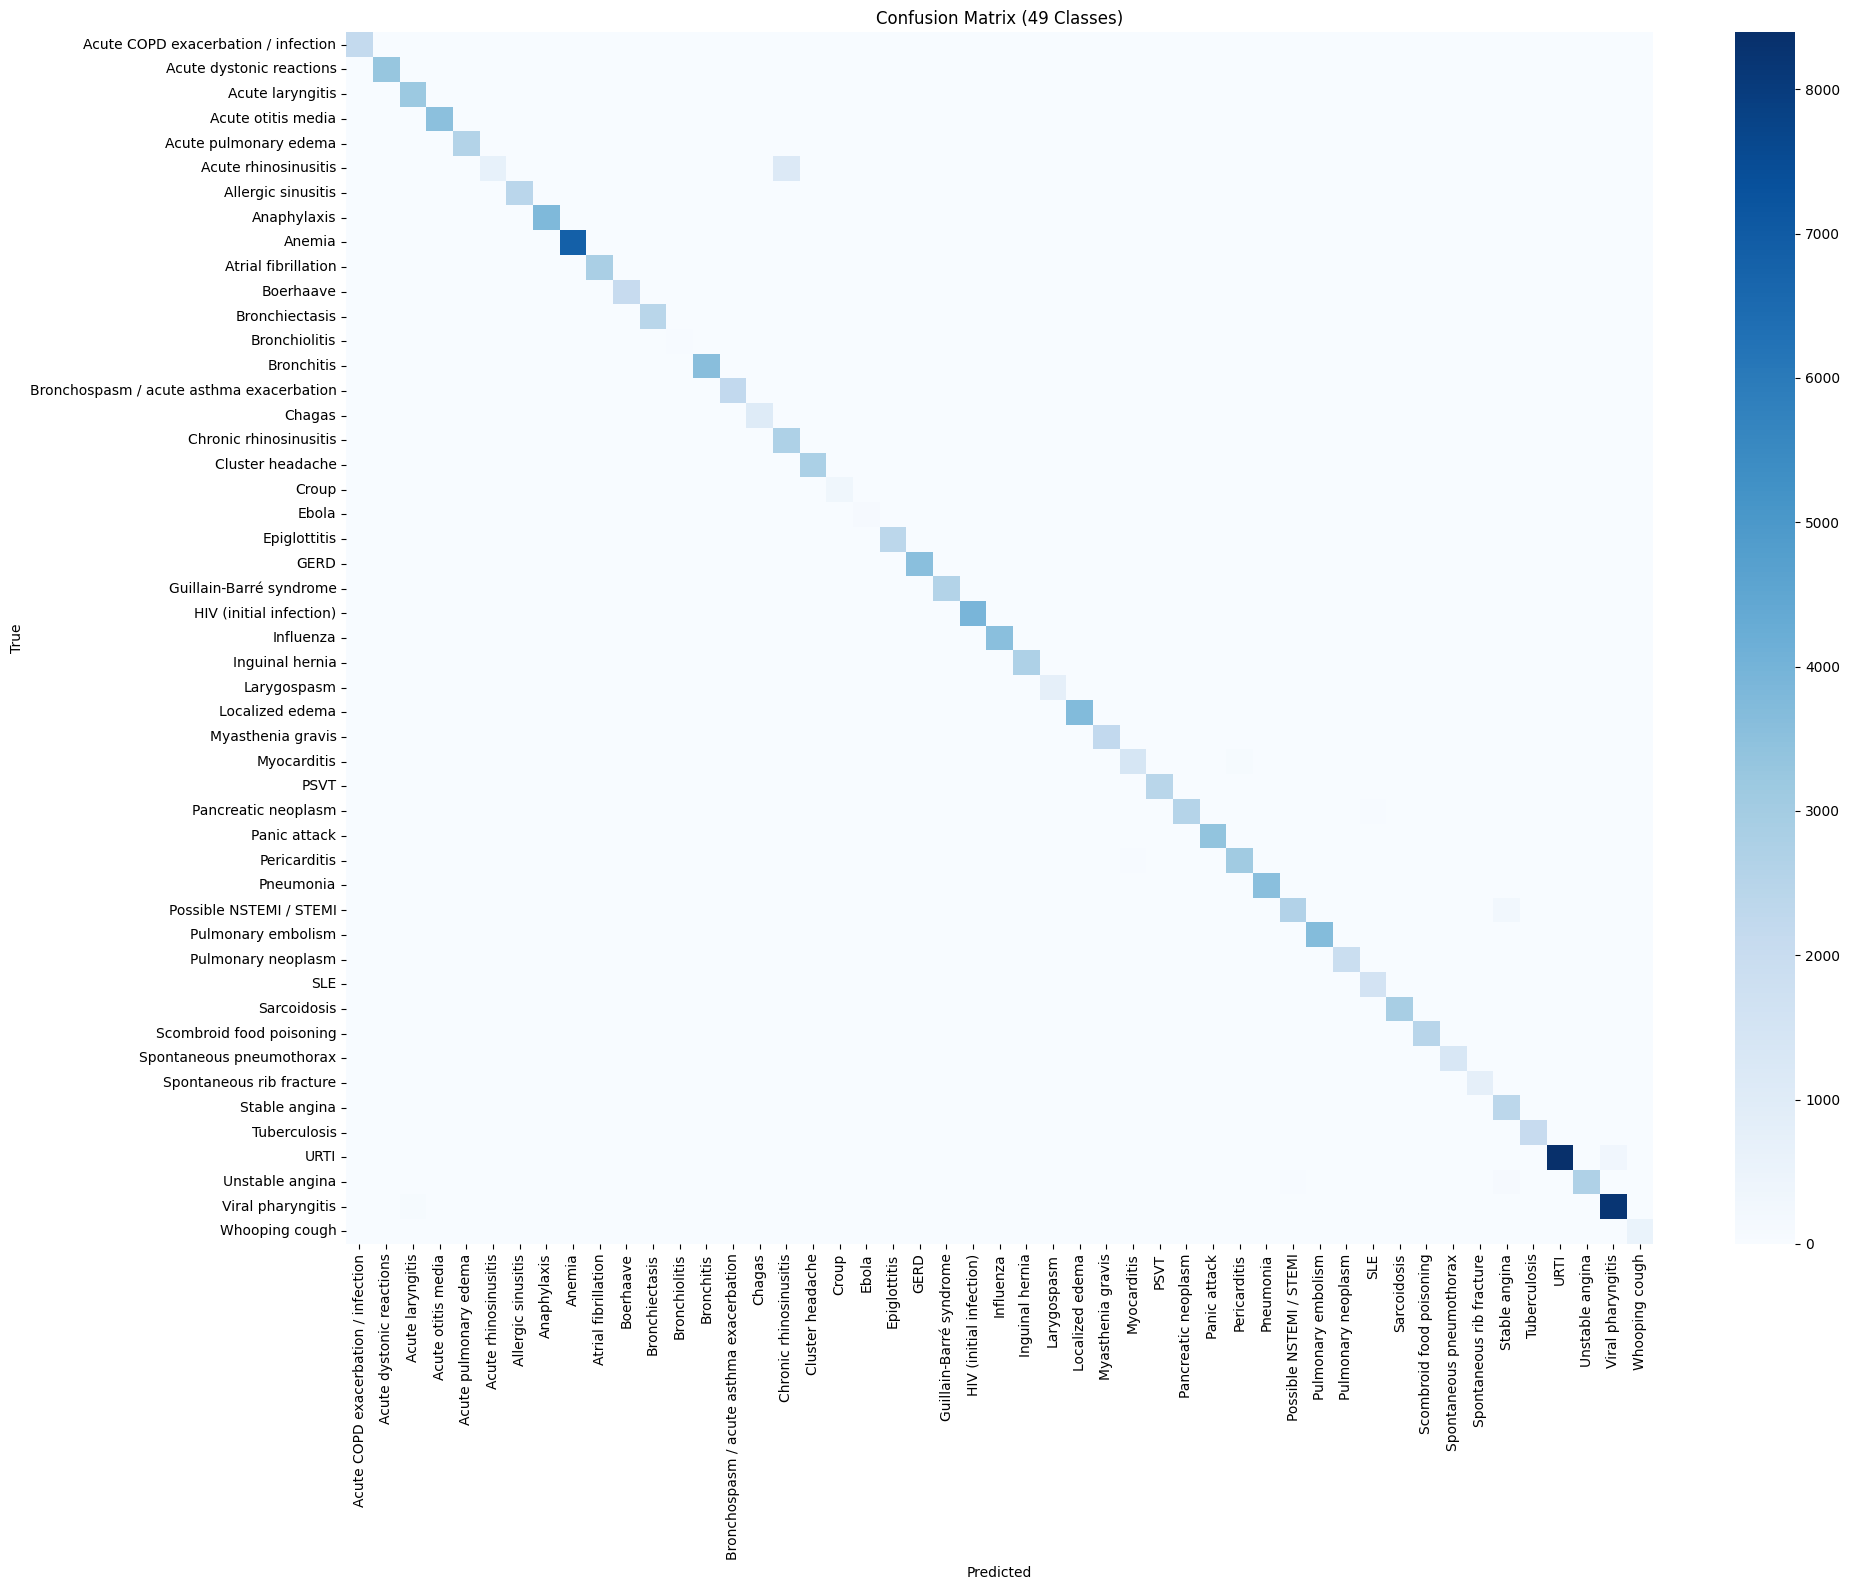

MOST CONFUSED PAIRS

Top 10 Confusion Pairs:
True Condition                      Predicted As                        Count    % of True
Acute rhinosinusitis                Chronic rhinosinusitis              1154     63.09%
URTI                                Viral pharyngitis                   322      3.68%
Possible NSTEMI / STEMI             Stable angina                       276      9.48%
Unstable angina                     Stable angina                       117      4.06%
Viral pharyngitis                   Acute laryngitis                    94       1.13%
Myocarditis                         Pericarditis                        85       5.75%
Unstable angina                     Possible NSTEMI / STEMI             65       2.26%
Pericarditis                        Myocarditis                         42       1.36%
Pancreatic neoplasm                 SLE                                 38       1.47%
URTI                                Bronchitis                          25      

In [6]:
print("CONFUSION MATRIX ANALYSIS")
# Get all condition names in order
conditions = list(label2id.keys())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=conditions)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(
    cm, 
    annot=False,
    fmt='d', 
    cmap='Blues',
    xticklabels=conditions,
    yticklabels=conditions,
    ax=ax
)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (49 Classes)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find most confused pairs
print("MOST CONFUSED PAIRS")

# Create confusion pairs
confusion_pairs = []
for i, true_cond in enumerate(conditions):
    for j, pred_cond in enumerate(conditions):
        if i != j and cm[i][j] > 0:
            confusion_pairs.append({
                'true': true_cond,
                'predicted': pred_cond,
                'count': cm[i][j],
                'pct_of_true': cm[i][j] / cm[i].sum() * 100 if cm[i].sum() > 0 else 0
            })

# Sort by count
confusion_pairs = sorted(confusion_pairs, key=lambda x: x['count'], reverse=True)

print("\nTop 10 Confusion Pairs:")
print(f"{'True Condition':<35} {'Predicted As':<35} {'Count':<8} {'% of True':<8}")

for pair in confusion_pairs[:10]:
    print(f"{pair['true']:<35} {pair['predicted']:<35} {pair['count']:<8} {pair['pct_of_true']:.2f}%")

###  Per-Class Metrics

PER-CLASS PERFORMANCE METRICS

Per-Class F1 Scores (sorted lowest to highest):
Condition                                Precision    Recall       F1-Score     Support   
Acute rhinosinusitis                     1.0000       0.3691       0.5391       1829      
Chronic rhinosinusitis                   0.7042       1.0000       0.8264       2747      
Stable angina                            0.8586       1.0000       0.9239       2386      
Possible NSTEMI / STEMI                  0.9759       0.9052       0.9392       2911      
Myocarditis                              0.9707       0.9425       0.9564       1478      
Unstable angina                          1.0000       0.9368       0.9674       2880      
Viral pharyngitis                        0.9603       0.9869       0.9734       8334      
SLE                                      0.9646       0.9930       0.9786       1564      
Pericarditis                             0.9723       0.9864       0.9793       3095      
URTI       

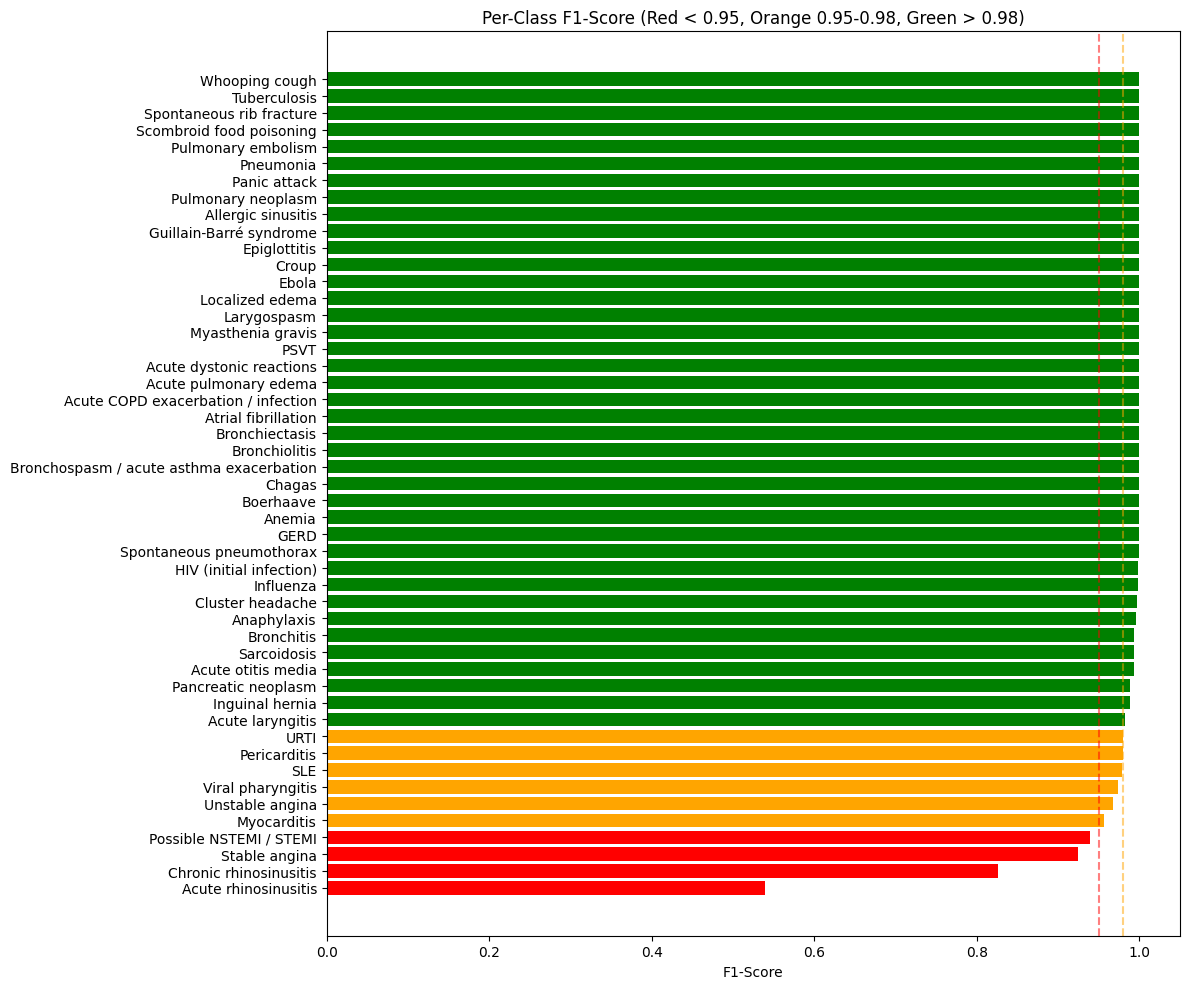

In [7]:
print("PER-CLASS PERFORMANCE METRICS")

# Generate classification report
report = classification_report(y_true, y_pred, target_names=conditions, output_dict=True)

# Convert to DataFrame
metrics_df = pd.DataFrame(report).T
metrics_df = metrics_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
metrics_df = metrics_df.sort_values('f1-score', ascending=True)

print("\nPer-Class F1 Scores (sorted lowest to highest):")

print(f"{'Condition':<40} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")

for condition, row in metrics_df.iterrows():
    print(f"{condition:<40} {row['precision']:<12.4f} {row['recall']:<12.4f} {row['f1-score']:<12.4f} {int(row['support']):<10}")

# Identify weak classes
weak_classes = metrics_df[metrics_df['f1-score'] < 0.95]

print("\n" + "-" * 60)
print("CLASSES WITH F1-SCORE < 0.95")
print("-" * 60)

if len(weak_classes) > 0:
    for condition, row in weak_classes.iterrows():
        print(f"{condition}: F1={row['f1-score']:.4f}")
else:
    print("All classes have F1-score >= 0.95")

# Visualize
fig, ax = plt.subplots(figsize=(12, 10))
colors = ['red' if f1 < 0.95 else 'green' if f1 > 0.98 else 'orange' 
          for f1 in metrics_df['f1-score']]
ax.barh(range(len(metrics_df)), metrics_df['f1-score'], color=colors)
ax.set_yticks(range(len(metrics_df)))
ax.set_yticklabels(metrics_df.index)
ax.set_xlabel('F1-Score')
ax.set_title('Per-Class F1-Score (Red < 0.95, Orange 0.95-0.98, Green > 0.98)')
ax.axvline(x=0.95, color='red', linestyle='--', alpha=0.5)
ax.axvline(x=0.98, color='orange', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Validation Summary

In [8]:
print("MODEL VALIDATION SUMMARY")

# Calculate overall metrics
overall_accuracy = (np.array(y_true) == np.array(y_pred)).mean()
overall_f1_macro = f1_score(y_true, y_pred, average='macro')
overall_f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("\nOVERALL METRICS:")
print(f"   Accuracy:    {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"   F1 (Macro):  {overall_f1_macro:.4f} ({overall_f1_macro*100:.2f}%)")
print(f"   F1 (Weighted): {overall_f1_weighted:.4f} ({overall_f1_weighted*100:.2f}%)")

print("\nVALIDATION CHECKS:")
print(f"   1. Data Leakage:     {'PASS' if len(exact_overlap) == 0 else '❌ FAIL'}")
print(f"   2. Class Imbalance:  {'PASS' if imbalance_ratio < 100 else '⚠️ WARNING'}")
print(f"   3. All Classes > 90% F1: {'PASS' if metrics_df['f1-score'].min() > 0.90 else '⚠️ WARNING'}")
print(f"   4. Confused Pairs:   {'PASS' if confusion_pairs[0]['pct_of_true'] < 5 else '⚠️ WARNING'}")

print("\nCONCLUSION:")
if len(exact_overlap) == 0 and overall_f1_macro > 0.95:
    print("    Model performance is GENUINE and ROBUST")
    print("   • No data leakage detected")
    print("   • High F1-macro indicates good performance across all classes")
    print("   • Model is suitable for production use")
else:
    print("  Some concerns detected - review details above")

MODEL VALIDATION SUMMARY

OVERALL METRICS:
   Accuracy:    0.9822 (98.22%)
   F1 (Macro):  0.9794 (97.94%)
   F1 (Weighted): 0.9810 (98.10%)

VALIDATION CHECKS:
   1. Data Leakage:     ❌ FAIL
   2. Class Imbalance:  ⚠️ WARNING
   3. All Classes > 90% F1: ⚠️ WARNING
   4. Confused Pairs:   ⚠️ WARNING

CONCLUSION:
  Some concerns detected - review details above


### Clean Evaluation (Remove Duplicates)

In [9]:
print("CLEAN EVALUATION (REMOVING DUPLICATES)")

# Get texts that appear in training set
train_texts_set = set(item['text'] for item in train_data)

# Filter test data to only include non-duplicate texts
clean_test_data = [item for item in test_data if item['text'] not in train_texts_set]

print(f"Original test samples: {len(test_data):,}")
print(f"Duplicate samples removed: {len(test_data) - len(clean_test_data):,}")
print(f"Clean test samples: {len(clean_test_data):,}")
print(f"Percentage removed: {(len(test_data) - len(clean_test_data)) / len(test_data) * 100:.2f}%")

# Generate predictions on clean test set

print("Generating predictions on clean test set...")

y_true_clean = []
y_pred_clean = []

batch_size = 100
total = len(clean_test_data)

for i in range(0, total, batch_size):
    batch = clean_test_data[i:i+batch_size]
    texts = [item['text'] for item in batch]
    true_labels = [item['condition'] for item in batch]
    
    predictions = classifier(texts)
    pred_labels = [p[0]['label'] for p in predictions]
    
    y_true_clean.extend(true_labels)
    y_pred_clean.extend(pred_labels)
    
    if (i // batch_size) % 10 == 0:
        print(f"   Progress: {i:,} / {total:,} ({i/total*100:.1f}%)")

print(f"\nPredictions complete: {len(y_pred_clean):,} samples")

CLEAN EVALUATION (REMOVING DUPLICATES)
Original test samples: 134,529
Duplicate samples removed: 133,654
Clean test samples: 875
Percentage removed: 99.35%
Generating predictions on clean test set...
   Progress: 0 / 875 (0.0%)

Predictions complete: 875 samples


### Clean Metrics

In [10]:
print("METRICS COMPARISON: ORIGINAL vs CLEAN")
# Calculate clean metrics
clean_accuracy = (np.array(y_true_clean) == np.array(y_pred_clean)).mean()
clean_f1_macro = f1_score(y_true_clean, y_pred_clean, average='macro')
clean_f1_weighted = f1_score(y_true_clean, y_pred_clean, average='weighted')

print(f"{'Metric':<20} {'Original (with leakage)':<25} {'Clean (no leakage)':<25} {'Difference':<15}")

print(f"{'Accuracy':<20} {overall_accuracy*100:<25.2f} {clean_accuracy*100:<25.2f} {(overall_accuracy - clean_accuracy)*100:+.2f}%")
print(f"{'F1 (Macro)':<20} {overall_f1_macro*100:<25.2f} {clean_f1_macro*100:<25.2f} {(overall_f1_macro - clean_f1_macro)*100:+.2f}%")
print(f"{'F1 (Weighted)':<20} {overall_f1_weighted*100:<25.2f} {clean_f1_weighted*100:<25.2f} {(overall_f1_weighted - clean_f1_weighted)*100:+.2f}%")

print("INTERPRETATION")

diff = (overall_accuracy - clean_accuracy) * 100

if diff < 1:
    print(" Minimal difference (<1%) - Original metrics are largely genuine")
    print("   Data leakage had minimal impact on reported accuracy")
elif diff < 3:
    print("Small difference (1-3%) - Some inflation due to leakage")
    print("   Clean metrics are still strong and model generalizes well")
elif diff < 5:
    print("Moderate difference (3-5%) - Notable inflation due to leakage")
    print("   Use clean metrics for reporting")
else:
    print("Large difference (>5%) - Significant inflation due to leakage")
    print("   Model may be memorizing rather than generalizing")

METRICS COMPARISON: ORIGINAL vs CLEAN
Metric               Original (with leakage)   Clean (no leakage)        Difference     
Accuracy             98.22                     99.31                     -1.10%
F1 (Macro)           97.94                     98.38                     -0.43%
F1 (Weighted)        98.10                     99.30                     -1.21%
INTERPRETATION
 Minimal difference (<1%) - Original metrics are largely genuine
   Data leakage had minimal impact on reported accuracy


### Investigate Overlap Source

In [12]:
print("INVESTIGATING DUPLICATE SOURCE")

# Reload raw data to check overlap at evidence level
import zipfile

# Load raw train data
with zipfile.ZipFile("../data/ddxplus/release_train_patients.zip", 'r') as z:
    with z.open(z.namelist()[0]) as f:
        raw_train_df = pd.read_csv(f)

# Load raw test data
with zipfile.ZipFile("../data/ddxplus/release_test_patients.zip", 'r') as z:
    with z.open(z.namelist()[0]) as f:
        raw_test_df = pd.read_csv(f)

print(f"Raw train samples: {len(raw_train_df):,}")
print(f"Raw test samples: {len(raw_test_df):,}")

# Check overlap at EVIDENCES level (raw symptom sets)
train_evidences = set(raw_train_df['EVIDENCES'].values)
test_evidences = set(raw_test_df['EVIDENCES'].values)

raw_overlap = train_evidences.intersection(test_evidences)

print(f"\nUnique evidence sets in train: {len(train_evidences):,}")
print(f"Unique evidence sets in test: {len(test_evidences):,}")
print(f"Overlapping evidence sets: {len(raw_overlap):,}")

# Calculate what percentage of test samples have overlapping evidences
test_overlap_count = sum(1 for e in raw_test_df['EVIDENCES'] if e in train_evidences)
print(f"\nTest samples with evidence sets that appear in train: {test_overlap_count:,} ({test_overlap_count/len(raw_test_df)*100:.2f}%)")

print("DIAGNOSIS")

if test_overlap_count / len(raw_test_df) > 0.5:
    print("   Overlap exists at RAW DATA level")
    print("   This is a characteristic of the DDXPlus synthetic dataset")
    print("   The same symptom patterns can appear in both splits")
else:
    print("Raw data has minimal overlap")
    print("   Overlap was created by our text processing (limiting to 12 symptoms)")

INVESTIGATING DUPLICATE SOURCE
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Raw train samples: 1,025,602
Raw test samples: 134,529

Unique evidence sets in train: 819,500
Unique evidence sets in test: 117,807
Overlapping evidence sets: 9,750

Test samples with evidence sets that appear in train: 26,333 (19.57%)
DIAGNOSIS
Raw data has minimal overlap
   Overlap was created by our text processing (limiting to 12 symptoms)
